In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from scipy.misc import derivative

import analysis_plotting_helper_functions_c3v3 as helper
import utils

In [3]:
data_dir = '/Users/rebekahzhang/data/behavior_data'
exp = "exp2"
data_folder = os.path.join(data_dir, exp)
figure_folder = os.path.join(data_dir, f'{exp}_figures')
os.makedirs(figure_folder, exist_ok=True)

print(data_folder)
print(figure_folder)

/Users/rebekahzhang/data/behavior_data/exp2
/Users/rebekahzhang/data/behavior_data/exp2_figures


In [4]:
# two_colors = plt.cm.viridis(np.linspace(0, 1, 2))
two_colors = ["#ffb400", "#9080ff"]
custom_palette = {'s': two_colors[0], 'l': two_colors[1]}

In [5]:
sessions_training = pd.read_csv(os.path.join(data_folder, f'sessions_training_{exp}.csv'))
sessions_training['period'] = sessions_training['session']//10
trials_training = utils.load_data(os.path.join(data_folder, 'trials_training_analyzed.csv'))

In [6]:
sessions_training.mouse.nunique()
sessions_training.groupby('group')['mouse'].nunique()

group
l    19
s    14
Name: mouse, dtype: int64

# Dataset overview

In [ ]:
print(f'{len(sessions_training)} sessions')
print(f'{len(trials_training)} trials')

In [ ]:
plt.figure(figsize=(10, 6))

session_counts = sessions_training.groupby(['period', 'group']).size().unstack(fill_value=0)
plt.plot(session_counts.index, session_counts['s'], marker='o', label='Short', color=custom_palette['s'])
plt.plot(session_counts.index, session_counts['l'], marker='s', label='Long', color=custom_palette['l'])

plt.xlabel('Period (10-day intervals)')
plt.ylabel('Number of Sessions')
plt.title('Session Count per Period by Group')
plt.legend()  # Add legend

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "session_count_by_period_by_group.png"))

In [ ]:
# Get training duration stats
training_duration = sessions_training.groupby('mouse')['session'].max()

plt.figure(figsize=(10, 6))
plt.hist(training_duration, bins=40, alpha=0.7, edgecolor='black')
plt.axvline(x=10, color='red', linestyle='--', label='Cutoff (10 sessions)')
plt.xlabel('Days Trained')
plt.ylabel('Number of Mice')
plt.title('Distribution of Training Duration')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "training_duration_distribution.png"))

### make wait df, 1 row per session

In [ ]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session', 'dir', 'group', 'period']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils.load_data(utils.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [ ]:
wait_df = generate_wait_df(sessions_training)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Calculate mean and std for each group by session
for group in wait_df['group'].unique():
    group_data = wait_df[wait_df['group'] == group]
    session_stats = group_data.groupby('session')['tw_mean'].agg(['mean', 'std']).reset_index()
    
    ax.plot(session_stats['session'], session_stats['mean'], marker='o', label=group, color=custom_palette[group])
    ax.fill_between(session_stats['session'], 
                   session_stats['mean'] - session_stats['std'],
                   session_stats['mean'] + session_stats['std'],
                   alpha=0.2, color=custom_palette[group])

ax.set_xlabel('Session')
ax.set_ylabel('Mean Time Waited')
ax.set_title('Mean Time Waited by Session')
ax.legend()
ax.set_ylim(0, 15)

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "tw_by_session_by_group.png"))

# Filter late sessions, early termination mice, outlier mice

### late sessions

In [ ]:
session_cap = 80

In [ ]:
sessions_training_caped = sessions_training.loc[sessions_training['session'] <= session_cap]
trials_training_caped = trials_training.loc[trials_training['session'] <= session_cap]

print(f'{len(sessions_training_caped)} sessions')
print(f'{len(trials_training_caped)} trials')

### early termination mice

In [ ]:
# Get mice with >= 10 sessions
valid_mice = training_duration[training_duration >= 10].index.tolist()
sessions_training_filtered1 = sessions_training_caped[sessions_training_caped['mouse'].isin(valid_mice)].reset_index(drop=True)
trials_training_filtered1 = trials_training_caped[trials_training_caped['mouse'].isin(valid_mice)].reset_index(drop=True)

print(f'{len(sessions_training_filtered1)} sessions')
print(f'{len(trials_training_filtered1)} trials')


In [ ]:
wait_by_session_filted1 = generate_wait_df(sessions_training_filtered1)

### outlier mice

In [ ]:
mice_s = sessions_training_filtered1[sessions_training_filtered1['group'] == 's']['mouse'].unique()
mice_l = sessions_training_filtered1[sessions_training_filtered1['group'] == 'l']['mouse'].unique()

s_colors = plt.cm.twilight(np.linspace(0, 1, len(mice_s)))
l_colors = plt.cm.twilight_shifted(np.linspace(0, 1, len(mice_l)))
s_mouse_palette = dict(zip(mice_s, s_colors))
l_mouse_palette = dict(zip(mice_l, l_colors))
mouse_palette = {**s_mouse_palette, **l_mouse_palette}

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

groups = ['s', 'l']
titles = ['Short Group Wait Time per Period by Mouse', 'Long Group Wait Time per Period by Mouse']

for ax, group, title in zip(axes, groups, titles):
    group_df = wait_by_session_filted1[wait_by_session_filted1['group'] == group]
    # Compute mean and std for each mouse and period
    agg = group_df.groupby(['mouse', 'period'], as_index=False).agg(
        tw_mean=('tw_mean', 'mean'),
        tw_std=('tw_mean', 'std'),
        n=('tw_mean', 'count')
    )
    # Calculate standard error
    agg['tw_se'] = agg['tw_std'] / np.sqrt(agg['n'])

    mice = agg['mouse'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(mice)))

    for mouse, color in zip(mice, colors):
        data = agg[agg['mouse'] == mouse].sort_values('period')
        ax.errorbar(
            data['period'], data['tw_mean'], yerr=data['tw_se'],
            fmt='-o', color=mouse_palette[mouse], label=mouse, alpha=0.8, lw=1, capsize=3
        )

    ax.set_xlabel('Training Period (10-day intervals)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(sorted(agg['period'].unique()))
    ax.grid(alpha=0.3)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=8, title='Mouse')

axes[0].set_ylabel('Mean Time Waited (s)', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "tw_by_mouse_by_period_by_group.png"))

In [ ]:
def generate_mouse_wait_df(wait_df):
    data_list = []
    wait_df_by_mouse = wait_df.groupby('mouse')
    for m, mouse_data in wait_df_by_mouse:
        avg_avg_tw = mouse_data['tw_mean'].mean()
        data = {"mouse": m, 'tw': avg_avg_tw, 'group':mouse_data.group.tolist()[0]}
        data_list.append(data)
    mouse_wait_df = pd.DataFrame(data_list).sort_values(by=['group','tw'])
    return mouse_wait_df

In [ ]:
mouse_wait_df = generate_mouse_wait_df(wait_by_session_filted1)
display(mouse_wait_df)

In [ ]:
def find_outlier_mice(mouse_wait_df, method='iqr', multiplier=3):
    """
    Find outlier mice within each group based on tw values.
    """
    outliers = []
    for group, group_data in mouse_wait_df.groupby('group'):
        tw = group_data['tw']
        if method == 'iqr':
            q1, q3 = tw.quantile([0.25, 0.75])
            iqr = q3 - q1
            lower, upper = q1 - multiplier * iqr, q3 + multiplier * iqr
            mask = (tw < lower) | (tw > upper)
        elif method == 'zscore':
            mean, std = tw.mean(), tw.std()
            mask = abs((tw - mean) / std) > multiplier
        else:
            raise ValueError("method must be 'iqr' or 'zscore'")
        for _, row in group_data[mask].iterrows():
            outliers.append({'mouse': row['mouse'], 'group': row['group'], 'tw': row['tw'],
                             'method': method, 'is_outlier': True})
    return pd.DataFrame(outliers)

In [ ]:
# Find outliers using IQR method
outliers_iqr = find_outlier_mice(mouse_wait_df, method='iqr', multiplier=1.5)
print("Outliers using IQR method (1.5x IQR):")
print(outliers_iqr)

# Find outliers using z-score method
outliers_zscore = find_outlier_mice(mouse_wait_df, method='zscore', multiplier=2.0)
print("\nOutliers using Z-score method (|z| > 2):")
print(outliers_zscore)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
group_order = ['s', 'l']
group_labels = ['Short', 'Long']

# Plot all mice
for i, group in enumerate(group_order):
    group_data = mouse_wait_df[mouse_wait_df['group'] == group]
    for _, mouse_row in group_data.iterrows():
        ax.scatter(i, mouse_row['tw'],
                   color=mouse_palette[mouse_row['mouse']],
                   alpha=0.8, s=100, zorder=1)

# Mark outliers with different markers
for i, group in enumerate(group_order):
    group_data = mouse_wait_df[mouse_wait_df['group'] == group]
    
    # IQR outliers (X marker)
    iqr_outliers = outliers_iqr[outliers_iqr['group'] == group]['mouse'].tolist()
    iqr_data = group_data[group_data['mouse'].isin(iqr_outliers)]
    ax.scatter([i] * len(iqr_data), iqr_data['tw'],
                color='k', s=80, marker='x', linewidth=3,
                label='IQR Outliers' if group == 's' else "", zorder=3)
    
    # Z-score outliers (diamond marker)
    zscore_outliers = outliers_zscore[outliers_zscore['group'] == group]['mouse'].tolist()
    zscore_data = group_data[group_data['mouse'].isin(zscore_outliers)]
    ax.scatter([i] * len(zscore_data), zscore_data['tw'],
                color='red', s=20, marker='D', linewidth=2,
                label='Z-score Outliers' if group == 's' else "", zorder=2)

ax.set_xlabel('Group')
ax.set_ylabel('Average Time Waited')
ax.set_title('Mouse Performance with Outlier Detection')
ax.set_xticks([0, 1])
ax.set_xticklabels(group_labels)
ax.set_xlim(-0.5, 1.5)
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "outlier_mouse_comparison_iqr_zscore.png"))

In [ ]:
outlier_mice = outliers_iqr['mouse'].tolist()

In [ ]:
sessions_training_filtered2 = sessions_training_filtered1[~sessions_training_filtered1['mouse'].isin(outlier_mice)]
trials_training_filtered2 = trials_training_filtered1[~trials_training_filtered1['mouse'].isin(outlier_mice)]
wait_by_session_filted2 = wait_by_session_filted1[~wait_by_session_filted1['mouse'].isin(outlier_mice)]

print(f'{len(sessions_training_filtered2)} sessions')
print(f'{len(trials_training_filtered2)} trials')

In [ ]:
means = trials_training_filtered2.groupby('group')['time_waited'].mean()
print("Short tw mean:", means.get('s', float('nan')))
print("Long tw mean:", means.get('l', float('nan')))

In [ ]:
sessions_training_filtered2.to_csv(os.path.join(data_folder, 'sessions_training_filtered2.csv'), index=False)
trials_training_filtered2.to_csv(os.path.join(data_folder, 'trials_training_filtered2.csv'), index=False)

### slicing based on trial numbers

In [ ]:
def split_trials_by_block_position(trials_df):
    """
    Split trials into early (first 25%), middle (50%), and late (last 25%)
    based on block_trial_num within each session and block.
    Returns three DataFrames: early, middle, late.
    """
    def label_period(x):
        n = len(x)
        early = int(np.ceil(n * 0.25))
        late = int(np.ceil(n * 0.75))
        labels = np.array(['early'] * early + ['middle'] * (late - early) + ['late'] * (n - late))
        return pd.Series(labels, index=x.index)

    trials_df = trials_df.copy()
    trials_df = trials_df.sort_values(['dir', 'block_num', 'block_trial_num'])
    trials_df['trial_period'] = trials_df.groupby(['dir', 'block_num'])['block_trial_num'].transform(label_period)

    trials_early = trials_df[trials_df['trial_period'] == 'early']
    trials_middle = trials_df[trials_df['trial_period'] == 'middle']
    trials_late = trials_df[trials_df['trial_period'] == 'late']
    return trials_early, trials_middle, trials_late

# Apply the function to split trials_training_filtered2
trials_training_filtered2_early, trials_training_filtered2_middle, trials_training_filtered2_late = split_trials_by_block_position(trials_training_filtered2)

# Print summary statistics
print("Trial splitting summary:")
print(f"Early trials (first 25%): {len(trials_training_filtered2_early)}")
print(f"Middle trials (50%): {len(trials_training_filtered2_middle)}")
print(f"Late trials (last 25%): {len(trials_training_filtered2_late)}")
print(f"Sum of three slices: {len(trials_training_filtered2_early) + len(trials_training_filtered2_middle) + len(trials_training_filtered2_late)}")
print(f"Compared to original: {len(trials_training_filtered2)}")

In [ ]:
# Print short and long mean for early, middle, and late trial slices
for period_name, trials_slice in zip(
    ['early', 'middle', 'late'],
    [trials_training_filtered2_early, trials_training_filtered2_middle, trials_training_filtered2_late]
):
    tw_short = trials_slice[trials_slice['group'] == 's'].time_waited.mean()
    tw_long = trials_slice[trials_slice['group'] == 'l'].time_waited.mean()
    print(f"{period_name.capitalize()} trials - Short tw mean: {tw_short:.3f}, Long tw mean: {tw_long:.3f}")

In [ ]:
# Save the three sliced datasets as CSV files
trials_training_filtered2_early.to_csv(os.path.join(data_folder, 'trials_training_filtered2_early.csv'), index=False)
trials_training_filtered2_middle.to_csv(os.path.join(data_folder, 'trials_training_filtered2_middle.csv'), index=False)
trials_training_filtered2_late.to_csv(os.path.join(data_folder, 'trials_training_filtered2_late.csv'), index=False)

# Performance Stats

In [7]:
sessions_training_filtered2 = pd.read_csv(os.path.join(data_folder, 'sessions_training_filtered2.csv'))
trials_training_filtered2 = pd.read_csv(os.path.join(data_folder, 'trials_training_filtered2.csv'))

In [8]:
print("Number of unique mice by group:")
print(sessions_training_filtered2.groupby('group')['mouse'].nunique())

print("Number of unique sessions by group:")
print(sessions_training_filtered2.groupby('group')['dir'].nunique())

Number of unique mice by group:
group
l    17
s    12
Name: mouse, dtype: int64
Number of unique sessions by group:
group
l    890
s    676
Name: dir, dtype: int64


In [9]:
sessions_tw_short = sessions_training_filtered2[sessions_training_filtered2['group'] == 's']['avg_tw']
sessions_tw_long = sessions_training_filtered2[sessions_training_filtered2['group'] == 'l']['avg_tw']
t_stat, p_value = stats.ttest_ind(sessions_tw_short, sessions_tw_long)
print(f"S: n={len(sessions_tw_short)}, mean={sessions_tw_short.mean():.3f}±{sessions_tw_short.std():.3f}s")
print(f"L: n={len(sessions_tw_long)}, mean={sessions_tw_long.mean():.3f}±{sessions_tw_long.std():.3f}s")
print(f"T-test: t={t_stat:.3f}, p={p_value}")

S: n=676, mean=2.674±2.240s
L: n=890, mean=4.636±3.835s
T-test: t=-11.852, p=4.310154586388674e-31


In [10]:
tw_short_all = trials_training_filtered2[trials_training_filtered2['group'] == 's'].time_waited
tw_long_all = trials_training_filtered2[trials_training_filtered2['group'] == 'l'].time_waited
t_stat, p_value = stats.ttest_ind(tw_short_all, tw_long_all)
print(f'{len(trials_training_filtered2)} all trials')
print(f"S: n={len(tw_short_all)}, mean={tw_short_all.mean():.3f}±{tw_short_all.std():.3f}s")
print(f"L: n={len(tw_long_all)}, mean={tw_long_all.mean():.3f}±{tw_long_all.std():.3f}s")
print(f"T-test: t={t_stat:.3f}, p={p_value}\n")

trials_training_filtered2_no_repeat = trials_training_filtered2[trials_training_filtered2['bg_repeats'] == 1]
tw_short_np = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 's'].time_waited
tw_long_np = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 'l'].time_waited
t_stat, p_value = stats.ttest_ind(tw_short_np, tw_long_np)
print(f'{len(trials_training_filtered2_no_repeat)} no repeat trials')
print(f"S: n={len(tw_short_np)}, mean={tw_short_np.mean():.3f}±{tw_short_np.std():.3f}s")
print(f"L: n={len(tw_long_np)}, mean={tw_long_np.mean():.3f}±{tw_long_np.std():.3f}s")
print(f"T-test: t={t_stat:.3f}, p={p_value}")

572276 all trials
S: n=268944, mean=2.255±4.366s
L: n=303332, mean=4.329±9.281s
T-test: t=-105.923, p=0.0

299762 no repeat trials
S: n=146591, mean=2.610±5.491s
L: n=153171, mean=6.064±11.721s
T-test: t=-102.561, p=0.0


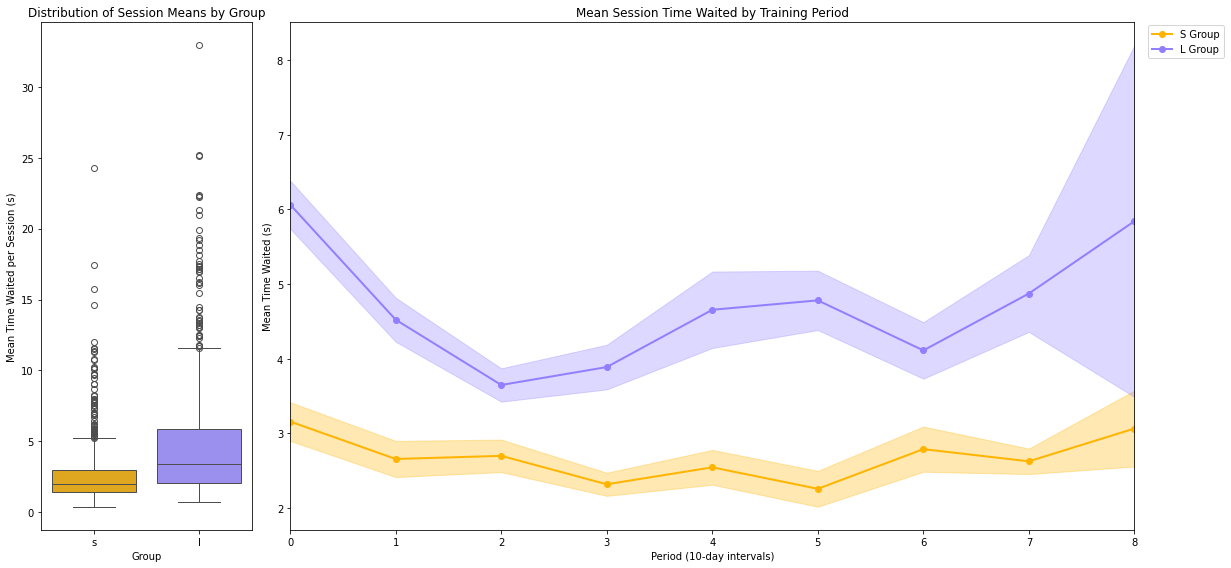

In [11]:
# Create figure with subplots (1 row, 2 columns with 1:3 width ratio)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 4]})

# Left subplot: Box plot
sns.boxplot(data=sessions_training_filtered2, x='group', y='avg_tw', hue='group', 
            palette=custom_palette, legend=False, ax=ax1)
ax1.set_xlabel('Group')
ax1.set_ylabel('Mean Time Waited per Session (s)')
ax1.set_title('Distribution of Session Means by Group')

# Right subplot: Line plot
# Calculate mean tw_mean by period and group
period_stats = sessions_training_filtered2.groupby(['period', 'group'])['avg_tw'].agg(['mean', 'std', 'count']).reset_index()
period_stats['se'] = period_stats['std'] / np.sqrt(period_stats['count'])

for group in ['s', 'l']:
    group_data = period_stats[period_stats['group'] == group]
    ax2.plot(group_data['period'], group_data['mean'], 
             marker='o', label=f'{group.upper()} Group', 
             color=custom_palette[group], linewidth=2, markersize=6)
    
    # Add error bars (standard error)
    ax2.fill_between(group_data['period'], 
                     group_data['mean'] - group_data['se'],
                     group_data['mean'] + group_data['se'],
                     alpha=0.3, color=custom_palette[group])

ax2.set_xlabel('Period (10-day intervals)')
ax2.set_ylabel('Mean Time Waited (s)')
ax2.set_title('Mean Session Time Waited by Training Period')
ax2.set_xlim(0, 8)

# Create single legend for the entire figure, positioned outside the plot area
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, 0.92))

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "avg_tw_by_period_by_group.png"))

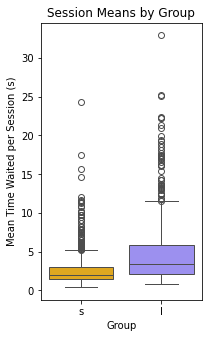

In [18]:
# Create a single box plot of Mean Time Waited per Session (s) by group
plt.figure(figsize=(3, 4.8))
sns.boxplot(data=sessions_training_filtered2, x='group', y='avg_tw', hue='group', 
            palette=custom_palette, legend=False)
plt.xlabel('Group')
plt.ylabel('Mean Time Waited per Session (s)')
plt.title('Session Means by Group')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "avg_tw_by_group.png"))

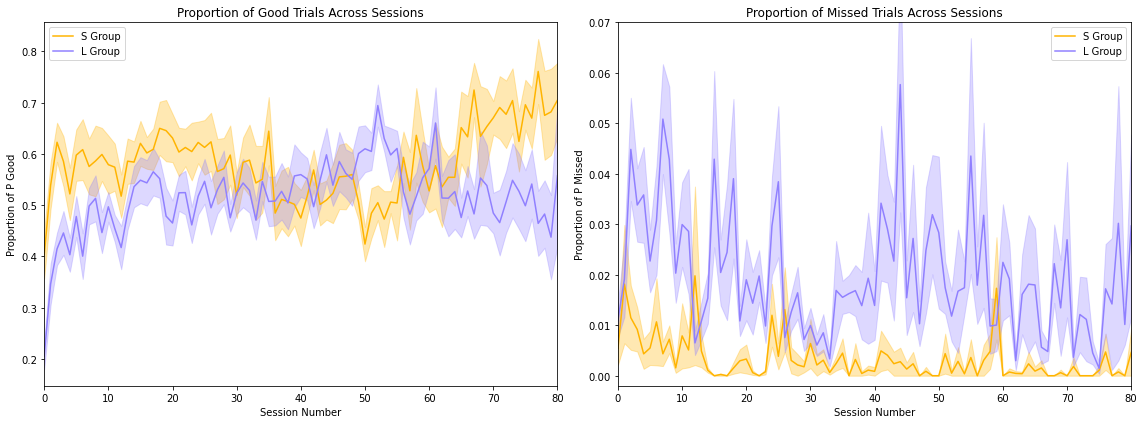

In [ ]:
# Calculate per-dir proportions of good and missed trials
def get_performance_by_dir(trials):
    results = []
    for _, d in trials.groupby('dir'):
        results.append({
            'group': d['group'].iloc[0],
            'session': d['session'].iloc[0],
            'p_good': d['good_trial'].mean(),
            'p_missed': d['miss_trial'].mean()
        })
    return pd.DataFrame(results)

performance_by_dir = get_performance_by_dir(trials_training_filtered2)

# Aggregate mean and standard error by group and session - simplified approach
trial_prop_stats = (
    performance_by_dir
    .groupby(['group', 'session'])[['p_good', 'p_missed']]
    .agg(['mean', 'std', 'count'])
    .reset_index()
)
trial_prop_stats.columns = ['group', 'session', 'p_good_mean', 'p_good_std', 'p_good_count', 'p_missed_mean', 'p_missed_std', 'p_missed_count']

# Calculate standard error
trial_prop_stats['p_good_se'] = trial_prop_stats['p_good_std'] / np.sqrt(trial_prop_stats['p_good_count'])
trial_prop_stats['p_missed_se'] = trial_prop_stats['p_missed_std'] / np.sqrt(trial_prop_stats['p_missed_count'])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, col, title, ylim in zip(
    axes,
    ['p_good', 'p_missed'],
    ['Proportion of Good Trials per Session Across Sessions', 'Proportion of Missed Trials per Session Across Sessions'],
    [None, (-0.002, 0.07)]
):
    for group in ['s', 'l']:
        data = trial_prop_stats[trial_prop_stats['group'] == group]
        ax.plot(data['session'], data[f'{col}_mean'], color=custom_palette[group], label=f'{group.upper()} Group')
        ax.fill_between(
            data['session'],
            data[f'{col}_mean'] - data[f'{col}_se'],
            data[f'{col}_mean'] + data[f'{col}_se'],
            color=custom_palette[group], alpha=0.3
        )
    ax.set(
        title=title,
        xlabel='Session Number',
        ylabel=f'Proportion of {col.replace("_", " ").title()}',
        xlim=(0, 80)
    )
    if ylim:
        ax.set_ylim(ylim)
    ax.legend()
plt.tight_layout()
plt.savefig(f'{figure_folder}/p_good_vs_missed_subplots_shading.png', dpi=300, bbox_inches='tight')


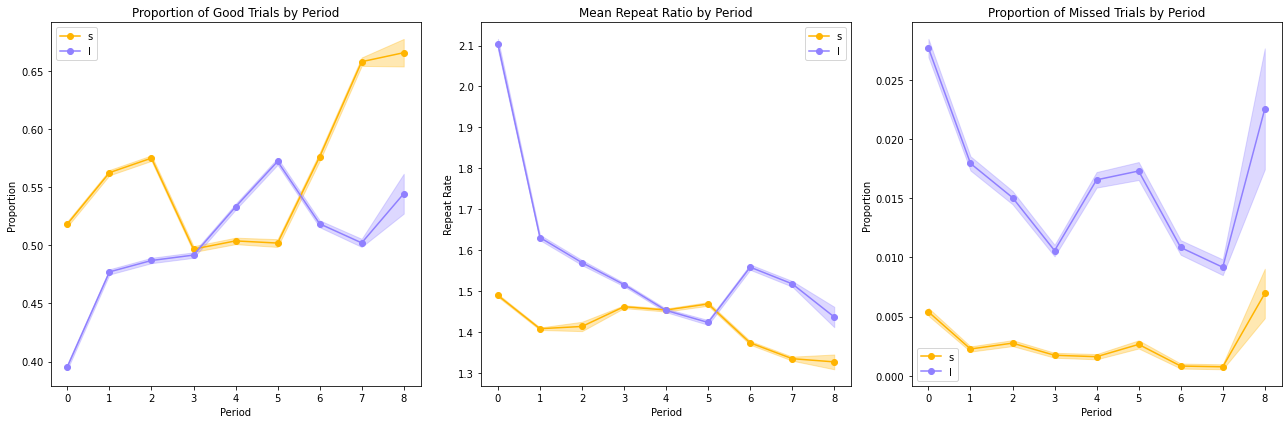

In [29]:
# Simplified 3-panel period analysis plot with shading for error
# Make the three plots in 1:1:1 ratio
fig, axes = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1]})
trials_training_filtered2['period'] = trials_training_filtered2['session'] // 10

# Helper for error bars
def binomial_se(p, n):
    return np.sqrt(p * (1 - p) / n)

groups = ['s', 'l']

# Left: Proportion of Good Trials by Period
good_stats = (
    trials_training_filtered2
    .groupby(['period', 'group'])['good_trial']
    .agg(['mean', 'count'])
    .unstack('group')
)
for group in groups:
    x = good_stats.index
    y = good_stats['mean', group]
    n = good_stats['count', group]
    se = binomial_se(y, n)
    axes[0].plot(x, y, label=group, color=custom_palette[group], marker='o')
    axes[0].fill_between(
        x,
        y - se,
        y + se,
        color=custom_palette[group],
        alpha=0.3
    )
axes[0].set(xlabel='Period', ylabel='Proportion', title='Proportion of Good Trials by Period')
axes[0].legend()

# Middle: Mean Repeat Ratio by Period
repeat_stats = (
    trials_training_filtered2
    .assign(ratio=lambda df: df['bg_length'] / df['bg_drawn'])
    .groupby(['period', 'group'])['ratio']
    .agg(['mean', 'std', 'count'])
    .unstack('group')
)
for group in groups:
    x = repeat_stats.index
    y = repeat_stats['mean', group]
    n = repeat_stats['count', group]
    se = repeat_stats['std', group] / np.sqrt(n)
    axes[1].plot(x, y, label=group, color=custom_palette[group], marker='o')
    axes[1].fill_between(
        x,
        y - se,
        y + se,
        color=custom_palette[group],
        alpha=0.3
    )
axes[1].set(xlabel='Period', ylabel='Repeat Rate', title='Mean Repeat Ratio by Period')
axes[1].legend()

# Right: Proportion of Missed Trials by Period
missed_stats = (
    trials_training_filtered2
    .groupby(['period', 'group'])['miss_trial']
    .agg(['sum', 'count'])
    .unstack('group')
)
for group in groups:
    x = missed_stats.index
    missed = missed_stats['sum', group]
    total = missed_stats['count', group]
    p = missed / total
    se = binomial_se(p, total)
    axes[2].plot(x, p, label=group, color=custom_palette[group], marker='o')
    axes[2].fill_between(
        x,
        p - se,
        p + se,
        color=custom_palette[group],
        alpha=0.3
    )
axes[2].set(xlabel='Period', ylabel='Proportion', title='Proportion of Missed Trials by Period')
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "trials_period_analysis_combined.png"))

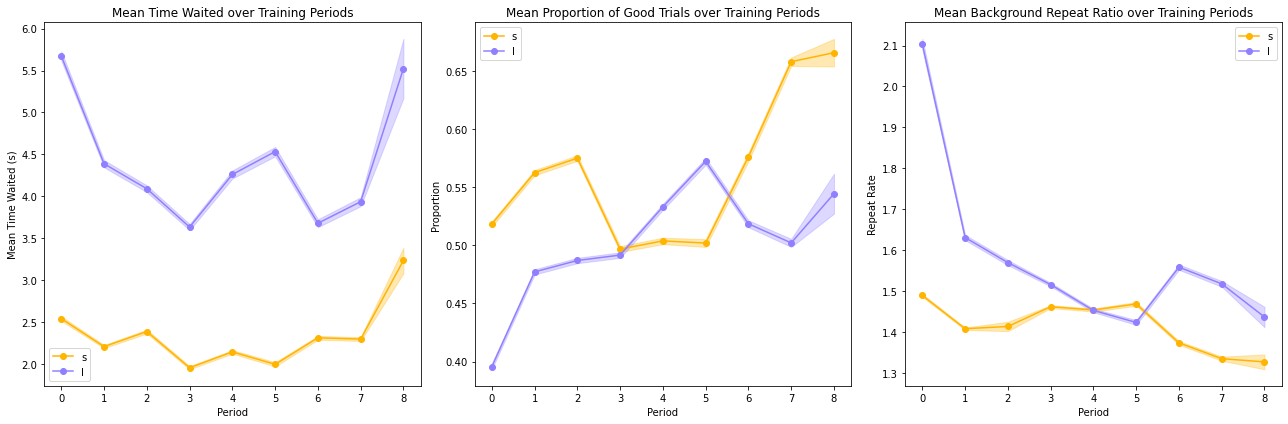

In [25]:
# Simplified three-panel plot: Mean tw, Good Trial Proportion, Repeat Ratio
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

trials_training_filtered2['period'] = trials_training_filtered2['session'] // 10
groups = ['s', 'l']
colors = custom_palette

def plot_with_error(ax, data, x, y, yerr, label, color):
    ax.plot(x, y, marker='o', label=label, color=color)
    ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.3)

# Left: Mean Time Waited
stats = trials_training_filtered2.groupby(['period', 'group'])['time_waited'] \
    .agg(['mean', 'std', 'count']).reset_index()
stats['se'] = stats['std'] / np.sqrt(stats['count'])
for g in groups:
    d = stats[stats['group']==g]
    plot_with_error(axes[0], d, d['period'], d['mean'], d['se'], g, colors[g])
axes[0].set(xlabel='Period', ylabel='Mean Time Waited (s)', title='Mean Time Waited over Training Periods')

# Middle: Proportion of Good Trials
def binomial_se(p, n): return np.sqrt(p * (1 - p) / n)
good = trials_training_filtered2.groupby(['period', 'group'])['good_trial'] \
    .agg(['mean', 'count']).reset_index()
good['se'] = binomial_se(good['mean'], good['count'])
for g in groups:
    d = good[good['group']==g]
    plot_with_error(axes[1], d, d['period'], d['mean'], d['se'], g, colors[g])
axes[1].set(xlabel='Period', ylabel='Proportion', title='Mean Proportion of Good Trials over Training Periods')

# Right: Mean Repeat Ratio
trials_training_filtered2['ratio'] = trials_training_filtered2['bg_length'] / trials_training_filtered2['bg_drawn']
rep = trials_training_filtered2.groupby(['period', 'group'])['ratio'] \
    .agg(['mean', 'std', 'count']).reset_index()
rep['se'] = rep['std'] / np.sqrt(rep['count'])
for g in groups:
    d = rep[rep['group']==g]
    plot_with_error(axes[2], d, d['period'], d['mean'], d['se'], g, colors[g])
axes[2].set(xlabel='Period', ylabel='Repeat Rate', title='Mean Background Repeat Ratio over Training Periods')

for ax in axes: ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "trials_period_analysis_combined.png"))

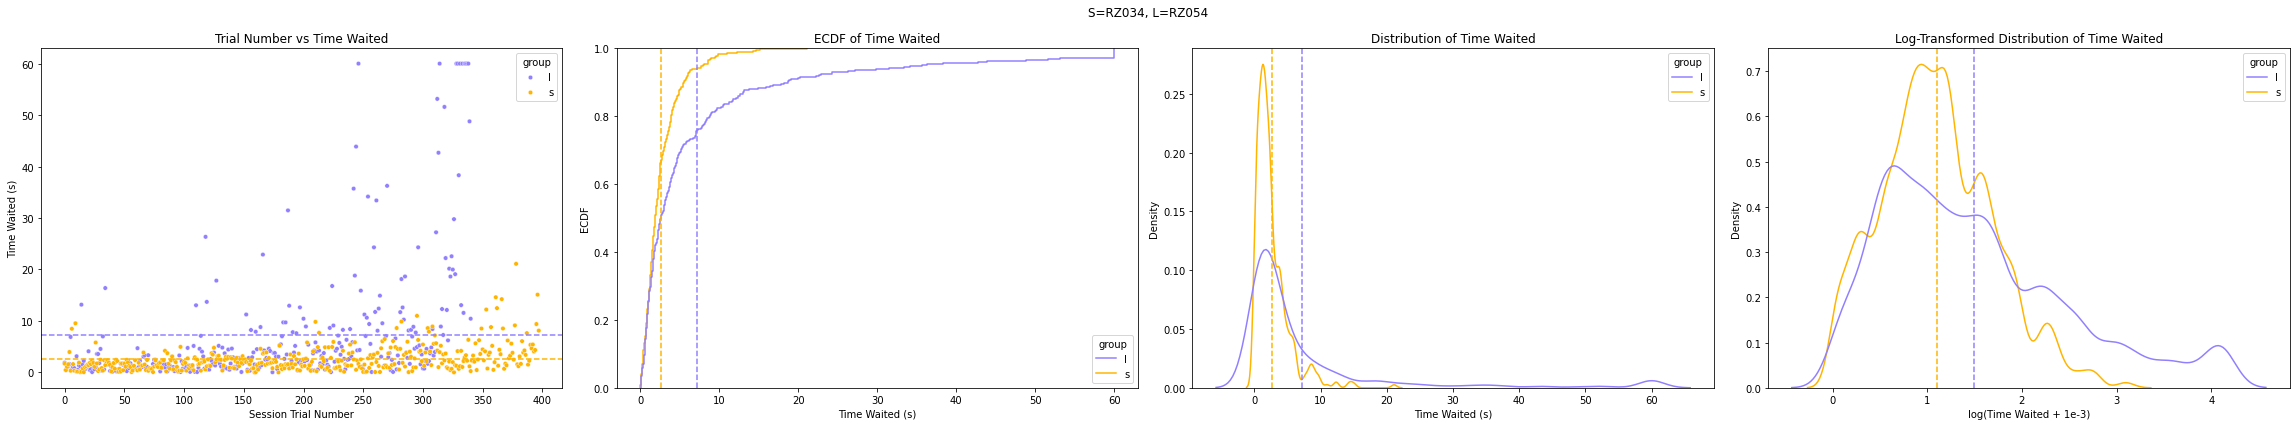

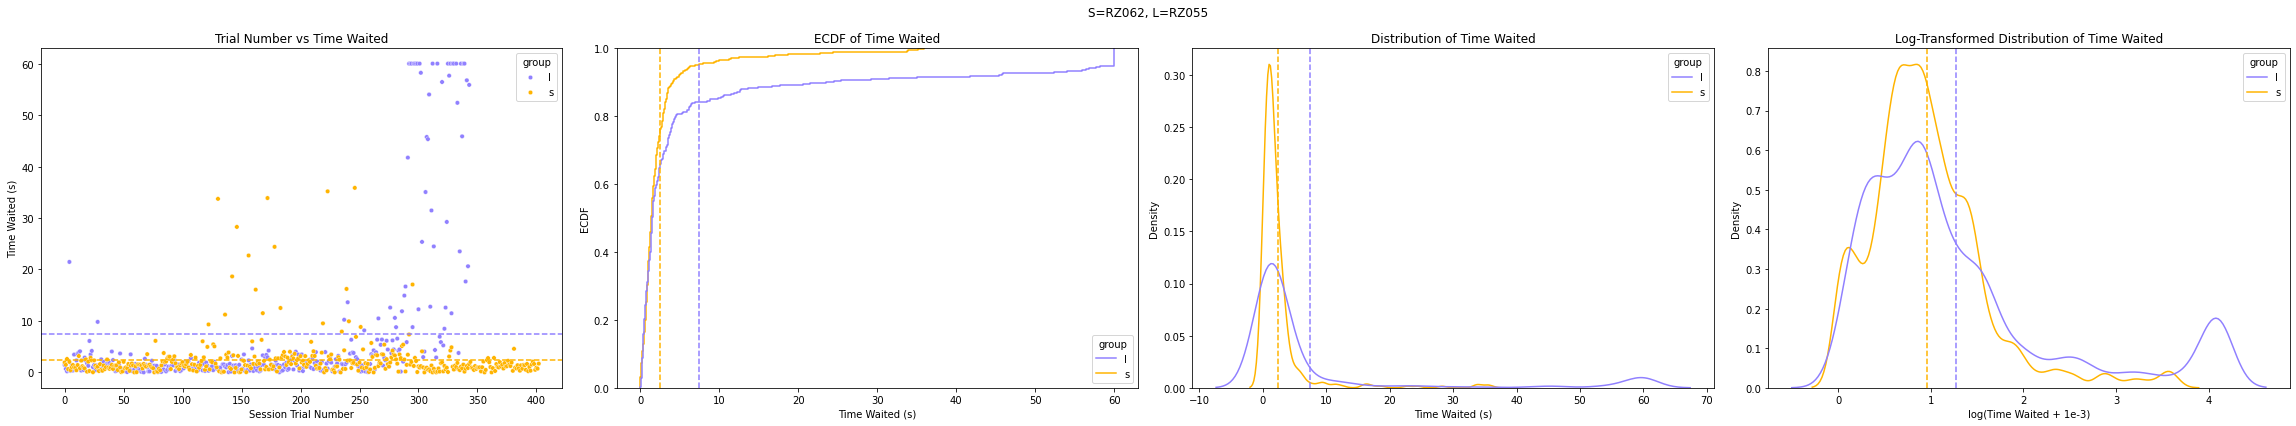

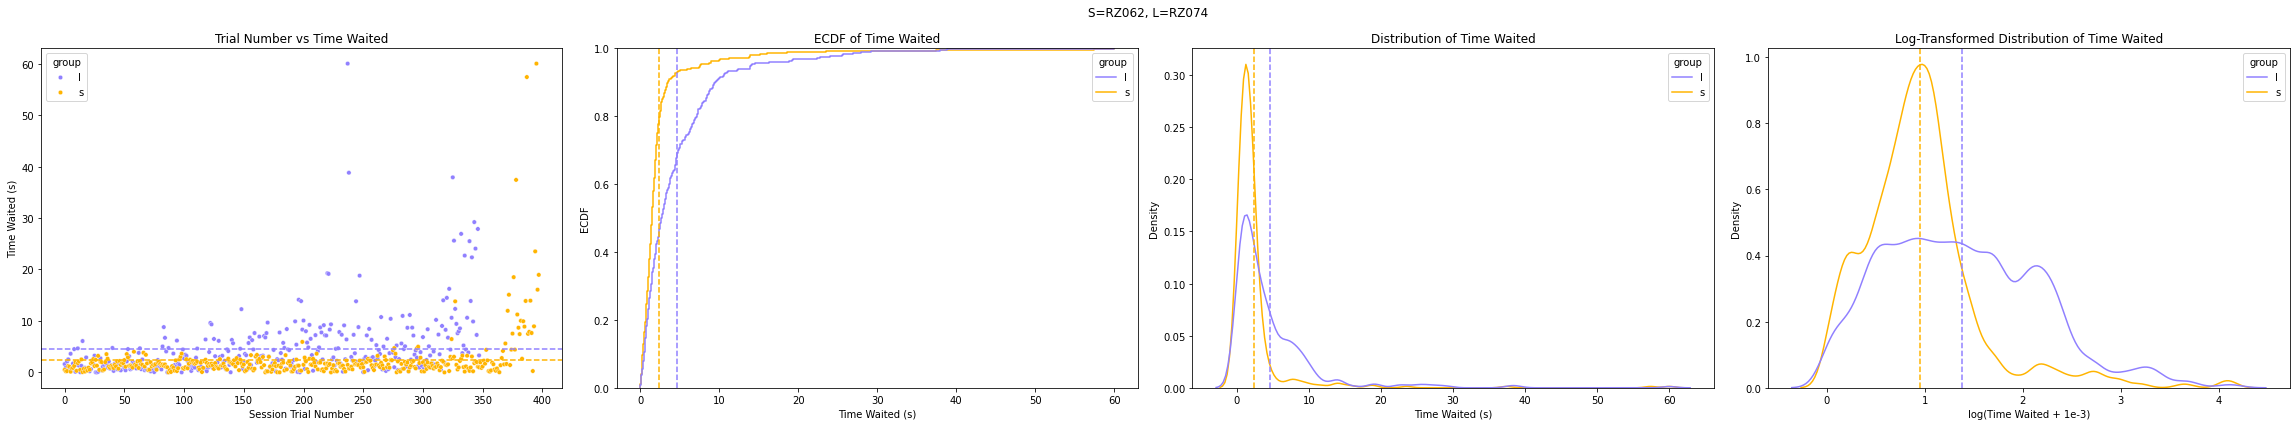

In [16]:
# Find 3 sessions closest to the mean for each group
def most_average_sessions(df, n=3):
    norm = (df[['avg_tw', 'num_trials']] - df[['avg_tw', 'num_trials']].mean()) / df[['avg_tw', 'num_trials']].std()
    dists = norm.pow(2).sum(axis=1)
    return df.loc[dists.nsmallest(n).index]

for group in ['s', 'l']:
    avg_sessions = most_average_sessions(sessions_training_filtered2[sessions_training_filtered2['group'] == group])
    if group == 's':
        avg_sessions_s = avg_sessions
    else:
        avg_sessions_l = avg_sessions

# Plot example sessions side-by-side
for i, (s_row, l_row) in enumerate(zip(avg_sessions_s.itertuples(), avg_sessions_l.itertuples()), 1):
    trials_short = utils.load_data(utils.generate_trials_analyzed_path(data_folder, sessions_training.loc[sessions_training.dir == s_row.dir].iloc[0]))
    trials_long = utils.load_data(utils.generate_trials_analyzed_path(data_folder, sessions_training.loc[sessions_training.dir == l_row.dir].iloc[0]))
    trials_examples = pd.concat([trials_long, trials_short])

    # Add log-transformed time waited column (avoid log(0) by adding small value)
    trials_examples = trials_examples.copy()
    trials_examples['log_time_waited'] = np.log1p(trials_examples['time_waited'])

    fig, axes = plt.subplots(1, 4, figsize=(32, 6))

    # Scatter, ECDF, KDE, and log-KDE plots for time waited by group
    plot_types = [
        ("session_trial_num", "time_waited", "Trial Number vs Time Waited", "Session Trial Number", "Time Waited (s)"),
        ("time_waited", None, "ECDF of Time Waited", "Time Waited (s)", "ECDF"),
        ("time_waited", None, "Distribution of Time Waited", "Time Waited (s)", "Density"),
        ("log_time_waited", None, "Log-Transformed Distribution of Time Waited", "log(Time Waited + 1e-3)", "Density"),
    ]
    for ax, (x, y, title, xlabel, ylabel) in zip(axes, plot_types):
        if title.startswith("Trial Number"):
            sns.scatterplot(x=x, y=y, hue="group", data=trials_examples, palette=custom_palette, s=20, ax=ax)
            for g in ['s', 'l']:
                mean_val = trials_examples.loc[trials_examples.group == g, y].mean()
                ax.axhline(mean_val, color=custom_palette[g], linestyle='--')
        elif title.startswith("ECDF"):
            sns.ecdfplot(data=trials_examples, x=x, hue="group", palette=custom_palette, ax=ax)
            for g in ['s', 'l']:
                mean_val = trials_examples.loc[trials_examples.group == g, x].mean()
                ax.axvline(mean_val, color=custom_palette[g], linestyle='--')
        elif title.startswith("Distribution"):
            sns.kdeplot(data=trials_examples, x=x, hue="group", common_norm=False, bw_adjust=0.5, palette=custom_palette, ax=ax)
            for g in ['s', 'l']:
                mean_val = trials_examples.loc[trials_examples.group == g, x].mean()
                ax.axvline(mean_val, color=custom_palette[g], linestyle='--')
        elif title.startswith("Log-Transformed"):
            sns.kdeplot(data=trials_examples, x=x, hue="group", common_norm=False, bw_adjust=0.5, palette=custom_palette, ax=ax)
            for g in ['s', 'l']:
                mean_val = trials_examples.loc[trials_examples.group == g, x].mean()
                ax.axvline(mean_val, color=custom_palette[g], linestyle='--')
        ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.suptitle(f'S={s_row.mouse}, L={l_row.mouse}')
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/example_sessions_pair_{i}.png', dpi=300, bbox_inches='tight')
    plt.show()

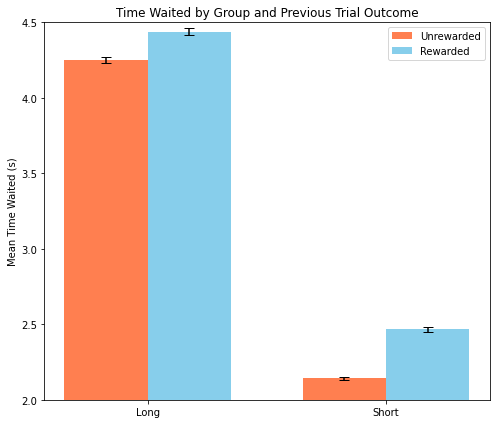

In [17]:
# Calculate mean and SEM of time waited by group and previous trial reward (0 or 5)
stats = (
    trials_training_filtered2[trials_training_filtered2['previous_trial_reward'].isin([0, 5])]
    .groupby(['group', 'previous_trial_reward'])['time_waited']
    .agg(['mean', 'sem'])
    .unstack()
)

# Plot
labels = ['Long' if g == 'l' else 'Short' for g in stats.index]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 6))
ax.bar(x - width/2, stats['mean'][0], width, yerr=stats['sem'][0], label='Unrewarded', color='coral', capsize=5)
ax.bar(x + width/2, stats['mean'][5], width, yerr=stats['sem'][5], label='Rewarded', color='skyblue', capsize=5)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Mean Time Waited (s)')
ax.set_title('Time Waited by Group and Previous Trial Outcome')
ax.set_ylim(2, 4.5)
ax.legend()
plt.tight_layout()
plt.savefig(f'{figure_folder}/time_waited_by_group_and_previous_trial_outcome.png', dpi=300, bbox_inches='tight')

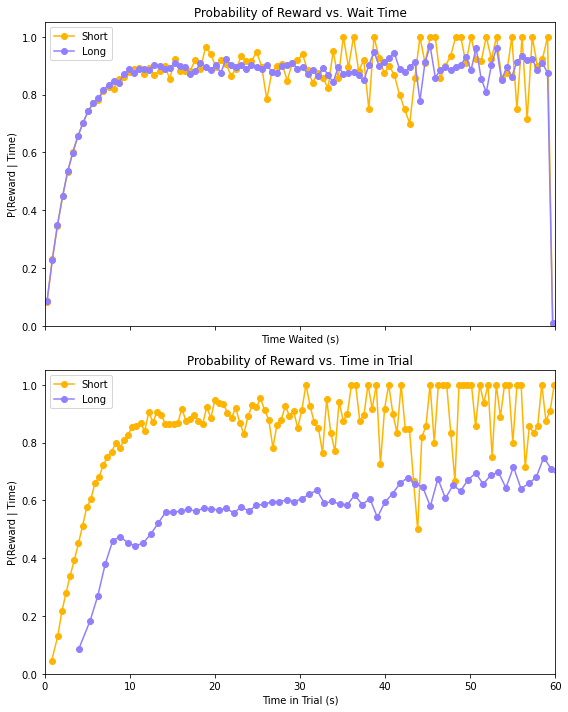

In [30]:
# Convert reward to binary
trials_training_filtered2['rewarded'] = (trials_training_filtered2['reward'] > 0).astype(int)
trials_training_filtered2['decision_time'] = trials_training_filtered2['bg_length'] + trials_training_filtered2['time_waited']

# Bin time_waited and compute mean reward per bin
trials_training_filtered2['time_bin'] = pd.cut(trials_training_filtered2['time_waited'], bins=100)
prob_df = trials_training_filtered2.groupby('time_bin', observed=True)['rewarded'].agg(['mean', 'count']).reset_index()
prob_df['time_midpoint'] = prob_df['time_bin'].apply(lambda x: x.mid)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Top plot: Probability of Reward vs. Wait Time, split by group
for group, label in zip(['s', 'l'], ['Short', 'Long']):
    color = custom_palette[group]
    df_group = trials_training_filtered2[trials_training_filtered2['group'] == group].copy()
    df_group['time_bin'] = pd.cut(df_group['time_waited'], bins=100)
    prob_df_group = df_group.groupby('time_bin', observed=True)['rewarded'].agg(['mean', 'count']).reset_index()
    prob_df_group['time_midpoint'] = prob_df_group['time_bin'].apply(lambda x: x.mid)
    ax1.plot(prob_df_group['time_midpoint'], prob_df_group['mean'], marker='o', label=label, color=color)

ax1.set_xlabel('Time Waited (s)')
ax1.set_ylabel('P(Reward | Time)')
ax1.set_title('Probability of Reward vs. Wait Time')
ax1.set_xlim(0, 60)
ax1.set_ylim(0, 1.05)
ax1.legend()

# Bottom plot: Probability of Reward vs. Time in Trial, split by group
for group, label in zip(['s', 'l'], ['Short', 'Long']):
    color = custom_palette[group]
    df_group = trials_training_filtered2[trials_training_filtered2['group'] == group].copy()
    df_group['time_bin'] = pd.cut(df_group['decision_time'], bins=1000)
    prob_df_group = df_group.groupby('time_bin', observed=True)['rewarded'].agg(['mean', 'count']).reset_index()
    prob_df_group['time_midpoint'] = prob_df_group['time_bin'].apply(lambda x: x.mid)
    ax2.plot(prob_df_group['time_midpoint'], prob_df_group['mean'], marker='o', label=label, color=color)

ax2.set_xlabel('Time in Trial (s)')
ax2.set_ylabel('P(Reward | Time)')
ax2.set_title('Probability of Reward vs. Time in Trial')
ax2.set_xlim(0, 60)
ax2.set_ylim(0, 1.05)
ax2.legend()

plt.tight_layout()
plt.savefig(f'{figure_folder}/reward_time_probability_combined.png', dpi=300, bbox_inches='tight')

In [19]:
rewarded = trials_training_filtered2[trials_training_filtered2['rewarded'] == 1].copy()
q_lo, q_hi = rewarded['decision_time'].quantile([0.01, 0.99])
rewarded = rewarded[(rewarded['decision_time'] >= q_lo) & (rewarded['decision_time'] <= q_hi)]

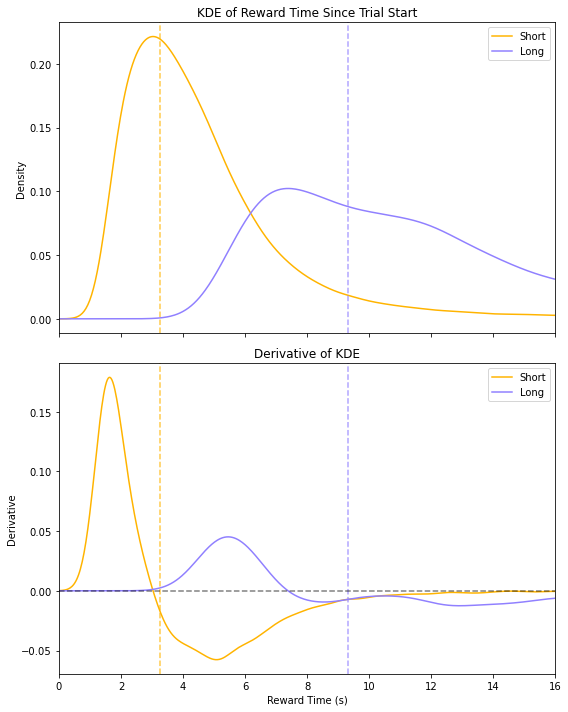

In [20]:
x = np.linspace(0, 30, 1000)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

for group, label in zip(['s', 'l'], ['Short', 'Long']):
    rt = rewarded.loc[rewarded['group'] == group, 'decision_time']
    kde = gaussian_kde(rt, bw_method=0.1)
    density = kde(x)
    ax1.plot(x, density, label=label, color=custom_palette[group])
    ax2.plot(x, np.gradient(density, x), label=label, color=custom_palette[group])

    # Add vertical line at (mean time waited + bg_length)
    mean_tw = trials_training_filtered2.loc[trials_training_filtered2['group'] == group, 'time_waited'].mean()
    bg = 1 if group == 's' else 5
    avline_val = bg + mean_tw
    for ax in (ax1, ax2):
        ax.axvline(avline_val, color=custom_palette[group], linestyle='--', alpha=0.7)

ax1.set_ylabel('Density')
ax1.set_title('KDE of Reward Time Since Trial Start')
ax1.legend()
ax2.set_xlabel('Reward Time (s)')
ax2.set_ylabel('Derivative')
ax2.set_title('Derivative of KDE')
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.legend()
plt.xlim(0, 16)
plt.tight_layout()
plt.savefig(f"{figure_folder}/reward_time_kde_and_derivative.png", dpi=300, bbox_inches='tight')

# LMEM

In [ ]:
# --- coding & centering ---
lmem_data = trials_training_filtered2.copy()
lmem_data['group_numeric'] = (lmem_data['group'] == 'l').astype(int)
session_mean = lmem_data['session'].mean()
trial_mean   = lmem_data['session_trial_num'].mean()

# scale session by 10 to help convergence
lmem_data['session_c'] = (lmem_data['session'] - session_mean) / 10.0
lmem_data['trial_c']   = lmem_data['session_trial_num'] - trial_mean

# --- fit: fixed = group × (session_c + session_c^2) + trial_c; random = intercept + session_c
model = smf.mixedlm(
    "time_waited ~ group_numeric * session_c + group_numeric * I(session_c**2) + trial_c",
    data=lmem_data,
    groups=lmem_data["mouse"],
    re_formula="~session_c"
)
result = model.fit(method="lbfgs")
print(result.summary())

In [ ]:
# --- prediction grid at mean trial (trial_c=0) ---
sessions_raw = np.linspace(lmem_data['session'].min(), lmem_data['session'].max(), 200)
sessions_c   = (sessions_raw - session_mean) / 10.0
groups = ['l', 's']

pred_df = pd.DataFrame({
    'session_raw': np.tile(sessions_raw, 2),
    'session_c':   np.tile(sessions_c, 2),
    'group':       np.repeat(groups, len(sessions_raw)),
    'trial_c':     0.0,  # predict at mean trial
    'mouse':       lmem_data['mouse'].iloc[0],
})
pred_df['group_numeric'] = (pred_df['group'] == 'l').astype(int)
pred_df['pred_time'] = result.predict(pred_df)

# --- empirical mean ± SE by session × group ---
session_stats = (
    lmem_data
    .groupby(['session', 'group'], as_index=False)
    .agg(
        mean_tw=('time_waited', 'mean'),
        std_tw =('time_waited', 'std'),
        count  =('time_waited', 'count')
    )
)
session_stats['se_tw'] = session_stats['std_tw'] / np.sqrt(session_stats['count'].clip(lower=1))

In [ ]:
plt.figure(figsize=(16, 6))
for g in groups:
    sel = pred_df['group'] == g
    plt.plot(
        pred_df.loc[sel, 'session_raw'],
        pred_df.loc[sel, 'pred_time'],
        '--', linewidth=3, color=custom_palette[g],
        label=f'{g.upper()} Group (LMEM Prediction, centered)'
    )
    gd = session_stats[session_stats['group'] == g]
    plt.plot(
        gd['session'], gd['mean_tw'],
        'o-', markersize=6, linewidth=2, color=custom_palette[g],
        label=f'{g.upper()} Group (Data)'
    )
    plt.fill_between(
        gd['session'],
        gd['mean_tw'] - gd['se_tw'],
        gd['mean_tw'] + gd['se_tw'],
        alpha=0.3, color=custom_palette[g]
    )

plt.title('LMEM Predictions vs Actual Data (centered predictors)', fontsize=14)
plt.xlabel('Session Number'); plt.ylabel('Time Waited (s)')
plt.legend(fontsize=11); plt.xlim(lmem_data['session'].min(), lmem_data['session'].max())
plt.ylim(bottom=0); plt.tight_layout()
plt.savefig(f'{figure_folder}/predictions_centered.png', dpi=300, bbox_inches='tight')

In [ ]:
# Simplified: population line is black, legend moved to right, code streamlined

def get_u0_u1(u):
    # Extract random intercept and slope for a mouse
    u0 = u.get('Intercept', u.get('const', u.get('Group', u.iloc[0] if hasattr(u, "iloc") else 0.0)))
    u1 = u.get('session_c', 0.0)
    return float(u0), float(u1)

fe = result.params
def fe_predict(session_c, group_numeric, trial_c=0.0):
    return (
        fe['Intercept']
        + fe.get('group_numeric', 0.0) * group_numeric
        + fe.get('session_c', 0.0) * session_c
        + fe.get('group_numeric:session_c', 0.0) * group_numeric * session_c
        + fe.get('I(session_c ** 2)', 0.0) * (session_c ** 2)
        + fe.get('group_numeric:I(session_c ** 2)', 0.0) * group_numeric * (session_c ** 2)
        + fe.get('trial_c', 0.0) * trial_c
    )

session_mean = lmem_data['session'].mean()
sessions_raw = np.linspace(lmem_data['session'].min(), lmem_data['session'].max(), 200)
sessions_c = (sessions_raw - session_mean) / 10.0

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
group_list = ['l', 's']

for i, g in enumerate(group_list):
    ax = axes[i]
    gn = 1 if g == 'l' else 0

    # Plot each mouse's fitted curve
    mice = lmem_data.loc[lmem_data['group'] == g, 'mouse'].unique()
    for m in mice:
        u = result.random_effects.get(m)
        if u is None:
            continue
        u0, u1 = get_u0_u1(u)
        y_mouse = fe_predict(sessions_c, gn) + u0 + u1 * sessions_c
        color = mouse_palette.get(m, "#888888")
        ax.plot(sessions_raw, y_mouse, color=color, alpha=0.8, linewidth=1.5, label=m)

    # Overlay population curve in black
    y_pop = fe_predict(sessions_c, gn)
    ax.plot(sessions_raw, y_pop, '--', color='black', linewidth=3, label='Population')

    ax.set_title(f"Group {g.upper()} Predicted Time Waited")
    ax.set_xlabel('Session')
    if i == 0:
        ax.set_ylabel('Time waited (s)')
    ax.set_xlim(0, 80)
    # Legend to the right of each subplot
    ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1.01))

plt.tight_layout()
plt.savefig(f'{figure_folder}/predictions_centered_by_group.png', dpi=300, bbox_inches='tight')


In [ ]:
ci = result.conf_int()
coef = result.params
coef_df = pd.DataFrame({
    'term': coef.index,
    'est': coef.values,
    'lo': ci[0].values,
    'hi': ci[1].values
})

fixed_mask = ~coef_df['term'].str.contains('^Group Var|^session_c Var|^Intercept Var|^Cov|^Scale', regex=True)
coef_df = coef_df[fixed_mask]

coef_df = coef_df.sort_values('est')
plt.figure(figsize=(8, max(4, 0.5*len(coef_df))))
plt.hlines(y=coef_df['term'], xmin=coef_df['lo'], xmax=coef_df['hi'])
plt.plot(coef_df['est'], coef_df['term'], 'o')
plt.axvline(0, color='k', linewidth=1, linestyle='--')
plt.title('Fixed effects (estimate ± 95% CI)')
plt.xlabel('Effect size'); plt.tight_layout()
plt.savefig(f'{figure_folder}/fixed_effects_ci.png', dpi=300, bbox_inches='tight')

In [ ]:
re_list = []
for m, u in result.random_effects.items():
    u0, u1 = (u.get('Intercept', u.get('const', u.get('Group', u.iloc[0]))),
              u.get('session_c', 0.0))
    re_list.append({'mouse': m, 'u0_intercept': float(u0), 'u1_session_c': float(u1)})
re_df = pd.DataFrame(re_list)

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.hist(re_df['u0_intercept'], bins=30)
plt.title('Random intercepts'); plt.xlabel('u0'); plt.ylabel('count')

plt.subplot(1,3,2)
plt.hist(re_df['u1_session_c'], bins=30)
plt.title('Random slopes (session_c)'); plt.xlabel('u1'); plt.ylabel('count')

plt.subplot(1,3,3)
plt.scatter(re_df['u0_intercept'], re_df['u1_session_c'], s=12, alpha=0.7)
plt.title('Intercept vs slope'); plt.xlabel('u0'); plt.ylabel('u1')
plt.tight_layout()

In [ ]:
resid = result.resid
fitted = result.fittedvalues

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Residuals vs Fitted
ax1.scatter(fitted, resid, s=1, alpha=0.4)
ax1.axhline(0, color='k', linestyle='--', linewidth=1)
ax1.set_xlabel('Fitted')
ax1.set_ylabel('Residual')
ax1.set_title('Residuals vs Fitted')

# Q-Q plot for residuals
sm.qqplot(resid, line='45', fit=True, ax=ax2)
ax2.set_title('Q-Q plot of residuals')

plt.tight_layout()